# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
%matplotlib inline

#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

import rdtools

/Users/traveler/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
print pvlib.__version__
print rdtools.__version__

0.4.4
1.0.1+28.gaf57155


# 1. <b>Standardize</b>

Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

http://dkasolarcentre.com.au/historical-data/download

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



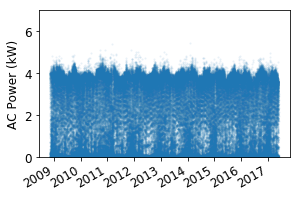

In [3]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv('84-Site_12-BP-Solar.csv')
df = df.rename(columns = {
    '12 BP Solar - Active Power (kW)':'power',
    '12 BP Solar - Wind Speed (m/s)': 'wind',
    '12 BP Solar - Weather Temperature Celsius (\xc2\xb0C)': 'Tamb',
    '12 BP Solar - Global Horizontal Radiation (W/m\xc2\xb2)': 'ghi',
    '12 BP Solar - Diffuse Horizontal Radiation (W/m\xc2\xb2)': 'dhi'
})
df.index = pd.to_datetime(df.Timestamp)
df.index = df.index.tz_localize('Australia/North') # TZ is required for irradiance transposition

# downsample
df = df.asfreq('15T') 

# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.power, 'o', alpha = 0.1)
ax.set_ylim(0,7)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (kW)');

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

In [4]:
# Metadata
lat = -23.762028
lon = 133.874886
azimuth = 0
tilt = 20
pdc = 5.1

meta = {"altitude":0,
       "latitude": lat,
       "longitude": lon,
       "Name": "Alice Springs",
       "State": "n/a",
       "TZ": 8.5}

# calculate the POA irradiance
sky = pvlib.irradiance.isotropic(tilt, df.dhi)

sun = pvlib.solarposition.get_solarposition(df.index, lat, lon)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(tilt, azimuth, sun.zenith, sun.azimuth, df.dni)

df['poa'] = beam + sky

# Calculate temperature
df_temp = pvlib.pvsystem.sapm_celltemp(df.poa, df.wind, df.Tamb, model = 'open_rack_cell_polymerback')
df['Tcell'] = df_temp.temp_cell

pv = pvlib.pvsystem.systemdef(meta, surface_tilt=tilt, surface_azimuth=azimuth, 
                              albedo=0.2, modules_per_string=6, strings_per_inverter=5)


pvwatts_kws = {"poa_global" : df.poa,
              "P_ref" : pdc,
              "T_cell" :df.Tcell,
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : -0.005}

normalized = rdtools.normalize_with_pvwatts(df.power, pvwatts_kws)

In [5]:
df.power.tail(n=50)

Timestamp
2017-05-25 08:30:00+09:30    0.295800
2017-05-25 08:45:00+09:30    0.478333
2017-05-25 09:00:00+09:30    0.965933
2017-05-25 09:15:00+09:30    0.988333
2017-05-25 09:30:00+09:30    1.173800
2017-05-25 09:45:00+09:30    1.200333
2017-05-25 10:00:00+09:30    1.085600
2017-05-25 10:15:00+09:30    1.147267
2017-05-25 10:30:00+09:30    0.808667
2017-05-25 10:45:00+09:30    3.237667
2017-05-25 11:00:00+09:30    3.302866
2017-05-25 11:15:00+09:30    3.406733
2017-05-25 11:30:00+09:30    1.867600
2017-05-25 11:45:00+09:30    3.732934
2017-05-25 12:00:00+09:30    2.624600
2017-05-25 12:15:00+09:30    3.639267
2017-05-25 12:30:00+09:30    2.901200
2017-05-25 12:45:00+09:30    3.760133
2017-05-25 13:00:00+09:30    3.500067
2017-05-25 13:15:00+09:30    3.413867
2017-05-25 13:30:00+09:30    3.379466
2017-05-25 13:45:00+09:30    3.300800
2017-05-25 14:00:00+09:30    3.213867
2017-05-25 14:15:00+09:30    3.141800
2017-05-25 14:30:00+09:30    3.031000
2017-05-25 14:45:00+09:30    2.917600
20

In [6]:
normalized

Timestamp
2008-11-11 00:00:00+09:30         NaN
2008-11-11 00:15:00+09:30         NaN
2008-11-11 00:30:00+09:30         NaN
2008-11-11 00:45:00+09:30         NaN
2008-11-11 01:00:00+09:30         NaN
2008-11-11 01:15:00+09:30         NaN
2008-11-11 01:30:00+09:30         NaN
2008-11-11 01:45:00+09:30         NaN
2008-11-11 02:00:00+09:30         NaN
2008-11-11 02:15:00+09:30         NaN
2008-11-11 02:30:00+09:30         NaN
2008-11-11 02:45:00+09:30         NaN
2008-11-11 03:00:00+09:30         NaN
2008-11-11 03:15:00+09:30         NaN
2008-11-11 03:30:00+09:30         NaN
2008-11-11 03:45:00+09:30         NaN
2008-11-11 04:00:00+09:30         NaN
2008-11-11 04:15:00+09:30         NaN
2008-11-11 04:30:00+09:30         NaN
2008-11-11 04:45:00+09:30         NaN
2008-11-11 05:00:00+09:30         NaN
2008-11-11 05:15:00+09:30         NaN
2008-11-11 05:30:00+09:30         NaN
2008-11-11 05:45:00+09:30         NaN
2008-11-11 06:00:00+09:30         NaN
2008-11-11 06:15:00+09:30         NaN
20

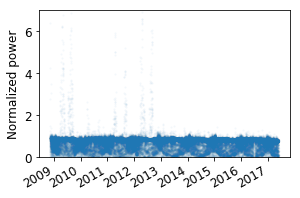

In [7]:
# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,7)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

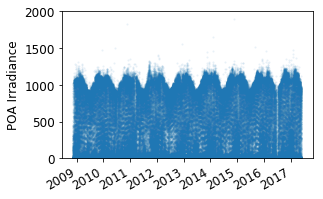

In [8]:
# plot the POA irradiance time series
fig, ax = plt.subplots()
ax.plot(df.index, df.poa, 'o', alpha = 0.1)
ax.set_ylim(0,2000)
fig.autofmt_xdate()
ax.set_ylabel('POA Irradiance');

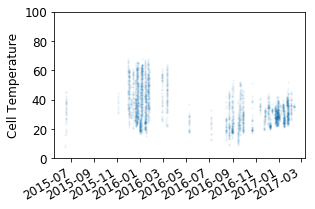

In [9]:
# plot the cell temperature time series
fig, ax = plt.subplots()
df_temp_plot = df
df_temp_plot = df_temp_plot.dropna()
ax.plot(df_temp_plot.index, df_temp_plot.Tcell.dropna(), 'o', alpha = 0.1)
ax.set_ylim(0,100)
fig.autofmt_xdate()
ax.set_ylabel('Cell Temperature');

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


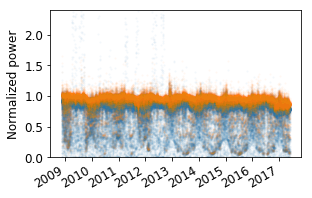

In [10]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future

df['normalized'] = normalized
filter_criteria = ((df['normalized']>0) & (df['normalized']<2) & (df.poa>200))

filtered = df[filter_criteria]['normalized']




#after filtering, center the data at PR_t0 = 1
def center_data(series):
    v = series.resample('12M').median().max()    
    return series / v

filtered = center_data(filtered)


# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.plot(filtered.index, filtered, 'o', alpha = 0.05)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [11]:
filtered

Timestamp
2008-11-13 17:00:00+09:30    0.916987
2008-11-13 17:15:00+09:30    0.869365
2008-11-13 17:30:00+09:30    0.692728
2008-11-14 07:15:00+09:30    0.286337
2008-11-14 07:30:00+09:30    0.268331
2008-11-14 07:45:00+09:30    0.177763
2008-11-14 08:00:00+09:30    0.605330
2008-11-14 08:15:00+09:30    0.731609
2008-11-14 08:30:00+09:30    0.759617
2008-11-14 08:45:00+09:30    0.890834
2008-11-14 09:00:00+09:30    1.010480
2008-11-14 09:15:00+09:30    1.009851
2008-11-14 09:30:00+09:30    1.022286
2008-11-14 09:45:00+09:30    1.030479
2008-11-14 10:00:00+09:30    1.031309
2008-11-14 10:15:00+09:30    1.031998
2008-11-14 10:30:00+09:30    1.026298
2008-11-14 10:45:00+09:30    1.011975
2008-11-14 11:00:00+09:30    1.017611
2008-11-14 11:15:00+09:30    1.005523
2008-11-14 11:30:00+09:30    1.005353
2008-11-14 11:45:00+09:30    0.997375
2008-11-14 12:00:00+09:30    1.003600
2008-11-14 12:15:00+09:30    1.015023
2008-11-14 12:30:00+09:30    1.018551
2008-11-14 12:45:00+09:30    1.025222
20

In [12]:
filtered.index

DatetimeIndex(['2008-11-13 17:00:00+09:30', '2008-11-13 17:15:00+09:30',
               '2008-11-13 17:30:00+09:30', '2008-11-14 07:15:00+09:30',
               '2008-11-14 07:30:00+09:30', '2008-11-14 07:45:00+09:30',
               '2008-11-14 08:00:00+09:30', '2008-11-14 08:15:00+09:30',
               '2008-11-14 08:30:00+09:30', '2008-11-14 08:45:00+09:30',
               ...
               '2017-05-25 14:45:00+09:30', '2017-05-25 15:00:00+09:30',
               '2017-05-25 15:15:00+09:30', '2017-05-25 15:30:00+09:30',
               '2017-05-25 15:45:00+09:30', '2017-05-25 16:00:00+09:30',
               '2017-05-25 16:15:00+09:30', '2017-05-25 16:30:00+09:30',
               '2017-05-25 16:45:00+09:30', '2017-05-25 17:00:00+09:30'],
              dtype='datetime64[ns, Australia/North]', name=u'Timestamp', length=108812, freq=None)

# 4. <b>Analyze</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.  The data may or may not be aggregated by this step.  



In [13]:
ols_rd, ols_ci, ols_info = rdtools.degradation.degradation_ols(filtered)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year''' % (ols_rd, ols_ci[0], ols_ci[1])

# yoy = rdtools.degradation.degradation_year_on_year(filtered)
# print "degradation_year_on_year", yoy

The degradation rate calculated with ols is -0.75 %/year
with a confidence interval of -0.77 to -0.73 %/year


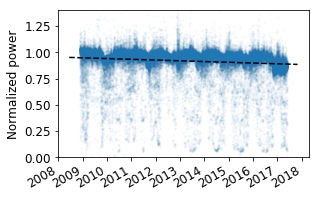

In [14]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered, 'o', alpha = 0.05)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')

ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [15]:
# Plot the year-on-year distribution
# YoY_filtered1 = yoy['YoY_filtered']
# YOY_median = yoy['Rd_median']
# plt.hist(YoY_filtered1, alpha=0.5, label='YOY', bins=int(YoY_filtered1.__len__()/4))
# plt.axvline(x=YOY_median, color='black', linestyle='dashed', linewidth=3)
# #plt.legend(loc='upper right')
# plt.title('Year-on-Year 15-minute Distribution \n Data outside +/-100 removed')   
# plt.tight_layout(w_pad=1, h_pad=2.0)
# plt.xlabel('Annual degradation (%)')